# Sample Functions for Analysis

In [1]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

import nltk
from nltk.collocations import *

import networkx as nx
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Preparations

In [33]:
# load data
rename_dict = {'id': 'text_id',
               'word_counts': 'word_count',
               'author': 'source',
              }

filepath="/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/twitterpolicydiscourse/data/"
coca_data = pd.read_csv(filepath + "refugee_coca_foranalysis.csv").drop(columns=['subgen'])
tweet_data = pd.read_csv(filepath + "twitter_data_to_concat.csv").drop(columns=['Unnamed: 0']).rename(columns=rename_dict)

In [34]:
# to concatenate coca and tweet data
data = pd.concat([coca_data, tweet_data], ignore_index=True)
print(len(data['text_id'].unique()), len(data)) #check that id is unique

48993 48993


In [35]:
# tokenize and normalize words
data['tokenized_words'] = data['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
data['normalized_words'] = data['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
data['normalized_words_POS'] = [lucem_illud_2020.spacy_pos(t) for t in data['text']]


# tokenize and normalize sentences
data['tokenized_sents'] = data['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [43]:
data.to_pickle("data/data_normalized.pkl")
# saving to csv does not return list type
#data.to_csv("data/data_normalized.csv", index=False)
#data = pd.read_csv("data/data_normalized.csv")

In [17]:
data = pd.read_pickle("data/data_normalized.pkl")

## Word/Phrase Frequency

In [41]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)

In [48]:
freq[:10]

,count
s,132529
refugee,56176
say,51158
not,45925
people,38552
think,31616
go,29493
year,27550
know,27113
come,23114


In [49]:
# get context
post_text = nltk.Text(data['tokenized_words'].sum())
index = nltk.text.ConcordanceIndex(post_text) 

In [50]:
index.print_concordance('refugee')

Displaying 25 of 26654 matches:
university and himself a 1960 cuban refugee mariels were driven less by politic
he wall photo black white below the refugee center where the suarezes and other
toon at second glance i look like a refugee farmer but careful examination reve
s guerrillas as we pass a family of refugee indians from the highlands dressed 
ople creating a massive and complex refugee problem half a million saudis egypt
tuation is of particular concern to refugee organizations if baghdad succeeds i
 an unusual briefing on the kuwaiti refugee dilemma and the palestinian aspect 
at they had better shut down contra refugee camps before michael dukakis became
ndcutting why not the fanjuls are a refugee family he says the economy of the c
ttee on the panama canal the aid to refugee chinese intellectuals among the bet
ms fell over themselves to hire any refugee from drexel s corporate finance dep
soviet army barracks into emergency refugee camps german officials speak uneasi
tino was

In [51]:
index.print_concordance('refugees')

Displaying 25 of 29522 matches:
w in the water jammed with 80 or so refugees some of them just released from cub
torm a documentary about the mariel refugees fate as he gazes at the hangar the 
ghter s future making a will mariel refugees belies the stigma that the cuban bo
lift s end in september some mariel refugees had committed murders burglaries or
where the suarezes and other mariel refugees section investing expanding petroch
uments and aerospace parts many are refugees from hightax california and unfortu
tytown later they met three teenage refugees from honduras the last surviving ma
y center casa oscar romero when the refugees brought out guitars the students le
ese newer immigrants were political refugees they were for the most part poor pe
5744 people mostly eastern european refugees then living in germany and austria 
gulations provided for thousands of refugees from hungary after the hungarian ri
ericans including relatively recent refugees or emigres or escapees from east

In [52]:
# common context
post_text.common_contexts(['refugees'])

so_some mariel_fate mariel_belies mariel_had mariel_section are_from
teenage_from the_brought political_they european_then of_from
recent_or of_in servants_who other_say asian_from for_reported
kuwaiti_most 60000_crossed new_as


/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/nltk/draw/__init__.py:15: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded " "(please install Tkinter library).")


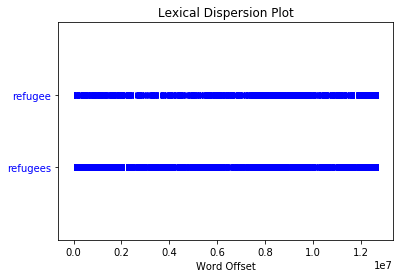

In [53]:
#Lexical Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
post_text.dispersion_plot(['refugee', 'refugees'])
sns.set() #Re-enabling seaborn

In [54]:
#Most common POS
def get_most_common_POS(data, years, genre=None):
    for yr in years:
        if genre:
            yearly = data[(data['genre']==genre) & (data['year']==yr)]
        else:
            yearly = data[data['year']==yr]
        freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in yearly['normalized_words_POS'].sum())
        print(yr)
        print("Most Common Nouns")
        print(freqdist_POStoWord['NN'].most_common(10))
        print()
        print("Most Common Adj")
        print(freqdist_POStoWord['JJ'].most_common(10))
        print()
        print("Most Common Verbs")
        print(freqdist_POStoWord['VB'].most_common(10))
        print()

In [3]:
years = sorted(data['year'].unique())
genres = data['genre'].unique()
genres

array(['MAG', 'SPOK', 'NEWS', 'twitter'], dtype=object)

In [55]:
get_most_common_POS(data, years)

1990
Most Common Nouns
[('time', 960), ('government', 933), ('today', 874), ('world', 786), ('country', 783), ('war', 689), ('way', 662), ('year', 565), ('mrlehrer', 535), ('day', 433)]

Most Common Adj
[('other', 1195), ('many', 821), ('new', 763), ('american', 621), ('last', 602), ('good', 571), ('iraqi', 564), ('military', 530), ('first', 495), ('soviet', 486)]

Most Common Verbs
[('be', 3592), ('have', 1320), ('do', 824), ('get', 708), ('go', 554), ('think', 488), ('take', 481), ('make', 479), ('say', 445), ('see', 404)]

1991
Most Common Nouns
[('war', 1339), ('time', 1246), ('government', 1092), ('today', 1072), ('country', 925), ('way', 892), ('world', 750), ('year', 657), ('mrlehrer', 578), ('day', 567)]

Most Common Adj
[('other', 1439), ('many', 1076), ('american', 835), ('iraqi', 834), ('new', 826), ('last', 811), ('good', 770), ('first', 673), ('political', 648), ('own', 568)]

Most Common Verbs
[('be', 4783), ('have', 1974), ('do', 1201), ('get', 883), ('go', 874), ('think

2006
Most Common Nouns
[('time', 721), ('world', 471), ('country', 459), ('government', 453), ('way', 448), ('day', 441), ('today', 417), ('war', 370), ('city', 370), ('family', 345)]

Most Common Adj
[('other', 669), ('many', 627), ('new', 571), ('last', 412), ('israeli', 387), ('first', 381), ('good', 329), ('american', 300), ('little', 281), ('own', 275)]

Most Common Verbs
[('be', 2129), ('have', 804), ('get', 545), ('do', 481), ('see', 397), ('go', 386), ('take', 366), ('make', 323), ('say', 254), ('come', 249)]

2007
Most Common Nouns
[('refugee', 623), ('time', 534), ('war', 469), ('government', 438), ('world', 418), ('camp', 413), ('year', 348), ('country', 345), ('today', 340), ('way', 336)]

Most Common Adj
[('other', 499), ('new', 421), ('many', 418), ('iraqi', 356), ('last', 303), ('first', 286), ('palestinian', 271), ('american', 257), ('good', 253), ('political', 231)]

Most Common Verbs
[('be', 1682), ('have', 719), ('do', 470), ('get', 357), ('go', 294), ('make', 272), 

In [56]:
genre = 'MAG'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

1990
Most Common Nouns
[('time', 207), ('year', 176), ('world', 171), ('photo', 147), ('state', 145), ('government', 139), ('city', 135), ('country', 127), ('family', 119), ('money', 116)]

Most Common Adj
[('other', 253), ('new', 223), ('many', 201), ('such', 159), ('american', 157), ('own', 123), ('first', 119), ('last', 117), ('foreign', 111), ('national', 107)]

Most Common Verbs
[('be', 674), ('have', 224), ('do', 116), ('get', 99), ('take', 90), ('make', 80), ('go', 70), ('see', 68), ('keep', 50), ('come', 43)]

1991
Most Common Nouns
[('time', 210), ('war', 157), ('world', 135), ('year', 117), ('photo', 114), ('way', 103), ('man', 94), ('day', 91), ('government', 88), ('history', 86)]

Most Common Adj
[('other', 209), ('new', 158), ('last', 146), ('many', 145), ('first', 144), ('american', 115), ('own', 111), ('few', 103), ('little', 98), ('black', 97)]

Most Common Verbs
[('be', 471), ('have', 199), ('do', 100), ('get', 87), ('take', 79), ('make', 75), ('go', 72), ('see', 58), 

2007
Most Common Nouns
[('world', 174), ('war', 159), ('time', 144), ('city', 133), ('country', 127), ('year', 115), ('government', 111), ('water', 107), ('day', 101), ('life', 94)]

Most Common Adj
[('other', 160), ('new', 142), ('many', 127), ('first', 108), ('own', 93), ('such', 88), ('last', 88), ('few', 81), ('global', 79), ('american', 75)]

Most Common Verbs
[('be', 459), ('have', 150), ('do', 110), ('get', 81), ('make', 75), ('see', 73), ('take', 69), ('help', 59), ('say', 51), ('go', 51)]

2008
Most Common Nouns
[('time', 118), ('war', 114), ('water', 87), ('government', 85), ('life', 82), ('world', 80), ('homer', 77), ('year', 74), ('day', 73), ('country', 72)]

Most Common Adj
[('other', 126), ('many', 113), ('new', 112), ('first', 83), ('own', 72), ('american', 62), ('last', 58), ('military', 58), ('iraqi', 55), ('such', 54)]

Most Common Verbs
[('be', 301), ('have', 110), ('do', 52), ('make', 52), ('take', 44), ('get', 41), ('go', 38), ('see', 37), ('come', 27), ('help', 2

In [57]:
genre = 'SPOK'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

1990
Most Common Nouns
[('today', 699), ('government', 630), ('time', 623), ('country', 541), ('mrlehrer', 535), ('world', 505), ('way', 466), ('war', 453), ('lot', 306), ('fact', 294)]

Most Common Adj
[('other', 715), ('many', 431), ('good', 420), ('new', 392), ('military', 360), ('last', 360), ('american', 355), ('iraqi', 330), ('soviet', 308), ('first', 270)]

Most Common Verbs
[('be', 2416), ('have', 962), ('do', 616), ('get', 525), ('think', 427), ('go', 420), ('say', 367), ('make', 330), ('let', 319), ('take', 304)]

1991
Most Common Nouns
[('war', 945), ('today', 893), ('time', 862), ('government', 751), ('country', 710), ('way', 646), ('mrlehrer', 578), ('king', 544), ('world', 475), ('question', 468)]

Most Common Adj
[('other', 942), ('many', 637), ('good', 631), ('iraqi', 573), ('american', 556), ('last', 514), ('new', 488), ('first', 399), ('political', 392), ('military', 385)]

Most Common Verbs
[('be', 3620), ('have', 1579), ('do', 989), ('go', 716), ('get', 713), ('thin

2006
Most Common Nouns
[('time', 415), ('today', 300), ('lot', 259), ('way', 253), ('day', 246), ('world', 244), ('country', 240), ('king', 207), ('government', 201), ('war', 193)]

Most Common Adj
[('other', 304), ('many', 246), ('israeli', 235), ('new', 217), ('good', 211), ('last', 199), ('first', 191), ('little', 171), ('next', 151), ('american', 134)]

Most Common Verbs
[('be', 1126), ('have', 495), ('get', 382), ('do', 299), ('see', 287), ('go', 247), ('take', 225), ('say', 176), ('make', 172), ('let', 166)]

2007
Most Common Nouns
[('time', 271), ('war', 228), ('today', 226), ('government', 195), ('way', 180), ('lot', 159), ('king', 149), ('world', 143), ('something', 140), ('country', 137)]

Most Common Adj
[('other', 240), ('many', 187), ('good', 142), ('new', 134), ('last', 134), ('american', 133), ('political', 124), ('iraqi', 98), ('same', 94), ('big', 85)]

Most Common Verbs
[('be', 839), ('have', 442), ('do', 287), ('get', 204), ('go', 178), ('think', 152), ('see', 149), 

In [58]:
genre = 'NEWS'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

1990
Most Common Nouns
[('government', 164), ('time', 130), ('war', 126), ('today', 118), ('country', 115), ('world', 110), ('year', 105), ('city', 103), ('life', 90), ('group', 88)]

Most Common Adj
[('other', 227), ('many', 189), ('iraqi', 189), ('new', 148), ('last', 125), ('soviet', 114), ('american', 109), ('first', 106), ('such', 104), ('military', 96)]

Most Common Verbs
[('be', 502), ('have', 134), ('do', 92), ('take', 87), ('get', 84), ('make', 69), ('go', 64), ('help', 58), ('know', 52), ('see', 45)]

1991
Most Common Nouns
[('government', 253), ('war', 237), ('time', 174), ('year', 153), ('border', 146), ('way', 143), ('world', 140), ('peace', 131), ('country', 130), ('today', 125)]

Most Common Adj
[('many', 294), ('other', 288), ('iraqi', 247), ('new', 180), ('american', 164), ('political', 161), ('kurdish', 160), ('last', 151), ('first', 130), ('military', 127)]

Most Common Verbs
[('be', 692), ('have', 196), ('do', 112), ('take', 87), ('go', 86), ('make', 83), ('get', 83

2006
Most Common Nouns
[('city', 157), ('time', 146), ('government', 135), ('year', 130), ('family', 125), ('percent', 106), ('war', 105), ('country', 103), ('state', 94), ('market', 92)]

Most Common Adj
[('many', 218), ('other', 207), ('new', 177), ('israeli', 149), ('last', 123), ('palestinian', 113), ('first', 111), ('american', 79), ('local', 70), ('international', 70)]

Most Common Verbs
[('be', 472), ('have', 114), ('do', 89), ('get', 79), ('take', 69), ('go', 69), ('make', 65), ('help', 55), ('see', 45), ('know', 39)]

2007
Most Common Nouns
[('government', 108), ('time', 106), ('year', 98), ('family', 88), ('life', 87), ('city', 83), ('school', 82), ('war', 73), ('world', 71), ('street', 71)]

Most Common Adj
[('new', 113), ('many', 98), ('other', 91), ('first', 83), ('last', 72), ('former', 55), ('iraqi', 55), ('political', 53), ('high', 49), ('palestinian', 48)]

Most Common Verbs
[('be', 335), ('have', 114), ('do', 63), ('get', 63), ('make', 61), ('go', 58), ('take', 36), (

In [59]:
genre = 'twitter'
genre_years = sorted(data[data['genre']==genre]['year'].unique())
get_most_common_POS(data, genre_years, genre)

2007
Most Common Nouns
[('refugee', 533), ('camp', 332), ('army', 47), ('fighting', 35), ('world', 30), ('crisis', 29), ('aid', 24), ('government', 24), ('source', 24), ('return', 24)]

Most Common Adj
[('iraqi', 176), ('lebanese', 157), ('palestinian', 132), ('new', 32), ('burmese', 23), ('islamist', 21), ('sudanese', 20), ('dead', 20), ('full', 18), ('first', 18)]

Most Common Verbs
[('be', 49), ('return', 20), ('have', 13), ('take', 12), ('do', 10), ('help', 10), ('start', 9), ('rise', 9), ('get', 9), ('let', 9)]

2008
Most Common Nouns
[('refugee', 1329), ('camp', 330), ('prayer', 98), ('today', 71), ('world', 68), ('day', 61), ('aid', 59), ('news', 55), ('time', 49), ('family', 47)]

Most Common Adj
[('iraqi', 199), ('new', 97), ('palestinian', 89), ('good', 53), ('first', 41), ('many', 41), ('last', 40), ('great', 38), ('sudanese', 36), ('burmese', 35)]

Most Common Verbs
[('be', 121), ('rise', 80), ('have', 79), ('help', 65), ('go', 44), ('get', 44), ('take', 42), ('live', 30), 

In [ ]:
# Word Cloud by year and genre
for yr in years:
    for g in genres:
        yearly = data[(data["genre"]==g) & (data['year']==yr)]
        words = yearly['normalized_words'].sum()
        if words==0:
            continue
        wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
        wc.to_file('wordcloud/data_{}_{}.png'.format(yr, g))

In [9]:
# Word Cloud by year
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    if words==0:
        continue
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(words))
    wc.to_file('wordcloud/data_{}_All.png'.format(yr))

In [10]:
# collocations
for yr in years:
    yearly = data[data['year']==yr]
    words = yearly['normalized_words'].sum()
    
    data_bigrams = nltk.collocations.BigramCollocationFinder.from_words(words)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    print(yr)
    print(data_bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:5])
    
    data_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(words)
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    print(data_trigrams.score_ngrams(trigram_measures.likelihood_ratio)[:5])
    
# other options include student_t, chi_sq, likelihood_ratio, pmi

1990
[(('unite', 'state'), 7242.095258047035), (('saddam', 'hussein'), 5070.514935596461), (('saudi', 'arabia'), 4574.108121239991), (('soviet', 'union'), 3964.4579606316947), (('khmer', 'rouge'), 3273.287562752811)]
[(('unite', 'state', 'baker'), 11150.260910882527), (('ambassador', 'unite', 'state'), 11130.192965367232), (('unite', 'state', 'soviet'), 10953.49391724261), (('unite', 'state', 'government'), 10935.590402072667), (('unite', 'state', 's'), 10925.819747032008)]
1991
[(('unite', 'state'), 8661.412428533353), (('saddam', 'hussein'), 7471.140858812556), (('soviet', 'union'), 4166.009223228741), (('new', 'york'), 3348.505297479314), (('abc', 'news'), 3267.0554730484187)]
[(('unite', 'state', 'baker'), 13268.918637990577), (('president', 'unite', 'state'), 13155.42015349009), (('unite', 'state', 'america'), 13075.725771298034), (('unite', 'state', 'israel'), 13070.265422139604), (('ambassador', 'unite', 'state'), 13068.338935056696)]
1992
[(('unite', 'state'), 4059.412346029798

[(('palestinian', 'refugee', 'camp'), 6608.448595311322), (('baqaa', 'refugee', 'camp'), 5474.888894323913), (('lebanon', 'refugee', 'camp'), 5451.593823284869), (('refugee', 'camp', 'lebanon'), 5381.115812869053), (('darfur', 'refugee', 'camp'), 5353.177858355824)]
2008
[(('refugee', 'camp'), 2710.016426403935), (('new', 'york'), 1285.9014996254236), (('unite', 'state'), 1281.1309966560802), (('iraqi', 'refugee'), 1125.7584002352075), (('wwwnewestdiscoverycom', 'update'), 959.7331460128814)]
[(('palestinian', 'refugee', 'camp'), 4842.11727337456), (('darfur', 'refugee', 'camp'), 4462.858540354538), (('un', 'refugee', 'camp'), 4415.882287727687), (('tibetan', 'refugee', 'camp'), 4408.143960835227), (('like', 'refugee', 'camp'), 4347.724445344288)]
2009
[(('refugee', 'camp'), 4192.072205268116), (('mankiewicz', 'voiceover'), 1376.6589954880797), (('sri', 'lanka'), 1270.346183714314), (('unite', 'state'), 1236.2636997923817), (('unite', 'nation'), 976.6402083252387)]
[(('iraqi', 'refugee

## Calculating Divergence

In [14]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [15]:
def plot_div_heatmap(corpora, fileids, diff_measure='KL'):
    '''
    Diff measure = KL, Chi2, KS or Wasserstein
    '''
    L = []
    for p in corpora:
        l = []
        for q in corpora:
            l.append(Divergence(p,q, difference = diff_measure))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = fileids, index = fileids)
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
# TO CHECK
corpora = data['normalized_words'][:2].sum()
# corpora = []
# for index, row in data.iterrows():
#     corpora.append(row['tokenized_words'])
fileids = list(data['text_id'][:2])
plot_div_heatmap(corpora, fileids,diff_measure='KL')

## Word Networks

In [4]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

def plot_word_graph(graph):
    layout = nx.spring_layout(graph, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    nx.draw(graph, ax = ax, pos = layout, labels = {n:n for n in graph.nodes()},
            width=.2, 
            alpha = .9, 
            node_size = 100,
            node_color = "xkcd:light red",
            edge_color='xkcd:black')

def plot_word_centrality(g):
    layout_nn = nx.spring_layout(g, weight='weight', iterations= 100)
    fig, ax = plt.subplots(figsize = (10,10))
    centralities_nn = nx.eigenvector_centrality(g)
    maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
    #maxWeight = max((d['weight'] for n1, n2, d in g.edges(data = True)))
    #minWeight = min((d['weight'] for n1, n2, d in g.edges(data = True)))
    nx.draw(g, ax = ax, pos = layout_nn, labels = {n: n for n in g.nodes()},
            #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
            alpha = .9, 
            node_color = [centralities_nn[n] / maxC for n in g.nodes],
            node_size = [centralities_nn[n] / maxC * 100 for n in g.nodes],
            font_size = 16,
            font_color = 'xkcd:dark grey',
            edge_color = 'xkcd:medium blue',
            cmap = plt.get_cmap('plasma'),
           )

### plot word network

In [ ]:
# plot word network
g = wordCooccurrence(data['normalized_sents'].sum())
len(g)

In [ ]:
weight_choice = 25
# remove if less than 25
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= weight_choice])
#since we are changing the graph list() evaluates the isolates first
g.remove_nodes_from(list(nx.isolates(g)))
# keep just the giant connected component
main_graph = max(connected_component_subgraphs(g), key=len)
print(nx.info(main_graph))

In [ ]:
plot_word_graph(main_graph)

In [ ]:
# plot sub-graph
immigrant_neighbors = main_graph.neighbors('family')
subgraph_immigrant = main_graph.subgraph(immigrant_neighbors)
print(nx.info(subgraph_immigrant))

plot_word_graph(subgraph_immigrant)

In [ ]:
# cliques
print(', '.join(max(nx.clique.find_cliques(main_graph), key = lambda x: len(x))))

### plot word network by pos

In [ ]:
# plot pos network
gNV = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV))

In [ ]:
degree_threshold= 100
weight_threshold = 2
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= degree_threshold]) 
print(nx.info(gNV))
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= weight_threshold])
print(nx.info(gNV))

In [ ]:
#TO CHECK
plot_word_centrality(gNV)

In [ ]:
# draw egocentric network
g_immigrant_NV = gNV.subgraph(['family'] + list(gNV.neighbors('family')))
print(nx.info(g_immigrant_NV))

In [ ]:
nx.draw_networkx(g_immigrant_NV)

### centrality & global measures

In [ ]:
#centralities

centralities = nx.degree_centrality(main_graph)
#centralities = nx.eigenvector_centrality(main_graph)
#centralities = nx.closeness_centrality(main_graph)
#centralities = nx.betweenness.betweenness_centrality(main_graph)
plt.hist(list(centralities.values()))
plt.show()

In [ ]:
name = 'degree'

centrality_df = pd.DataFrame.from_dict(centralities, orient='index', columns=[name])
centrality_df.sort_values(by=name, ascending=False, inplace=True)
#highest 10
centrality_df[:10]

In [ ]:
#global measures
density = nx.density(main_graph)
mean_degree_pernode = np.mean([v for w,v in nx.degree(main_graph)])
diameter = nx.diameter(main_graph)
print(
"The density of this graph is {}\n\
Mean degree per node is {}\n\
Diameter of graph is {}".format(density, mean_degree_pernode, diameter))

## Clustering

In [3]:
# TFIDF vectoriser
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])

For 2 clusters, average silhouette score is 0.021088308321032177
For 3 clusters, average silhouette score is 0.01948034099746146
For 4 clusters, average silhouette score is 0.02073743099077297
For 5 clusters, average silhouette score is 0.023149696277986263
For 6 clusters, average silhouette score is 0.01981980218193442
For 7 clusters, average silhouette score is 0.025006490040207798
For 8 clusters, average silhouette score is 0.02924122660270278
For 9 clusters, average silhouette score is 0.03027735674778955


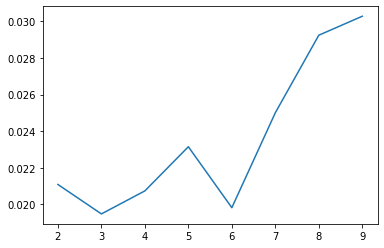

In [4]:
def find_best_n(X, max=10):
    clusters = []
    s_avg = []
    for i in range(2, max):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

X = dataVects.toarray()
find_best_n(X)

In [5]:
num_cluster = 8
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')
km.fit(dataVects)
data['kmeans_prediction'] = km.labels_

In [6]:
def get_top_words(km, num_cluster, data_vectoriser):
    terms = data_vectoriser.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(num_cluster):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :20]:
            print(' %s' % terms[ind])
        print('\n')

get_top_words(km, num_cluster, data_vectoriser)

Top terms per cluster:
Cluster 0:
 amp
 refugees
 refugee
 children
 syria
 syrian
 women
 help
 asylum
 people
 camps
 crisis
 new
 camp
 today
 migrants
 support
 need
 displaced
 rights


Cluster 1:
 refugee
 camps
 crisis
 children
 new
 world
 status
 day
 like
 agency
 help
 just
 asylum
 syria
 people
 canada
 women
 story
 says
 immigration


Cluster 2:
 iraqi
 iraq
 refugees
 refugee
 syria
 jordan
 iran
 baghdad
 crisis
 unhcr
 help
 million
 said
 iraqis
 war
 aid
 food
 says
 home
 new


Cluster 3:
 camp
 refugee
 palestinian
 lebanon
 syria
 refugees
 gaza
 syrian
 photo
 children
 army
 largest
 new
 people
 killed
 like
 israeli
 day
 jordan
 palestinians


Cluster 4:
 refugees
 syria
 people
 help
 unhcr
 new
 asylum
 world
 trump
 million
 home
 palestinian
 fleeing
 just
 children
 like
 border
 country
 today
 migrants


Cluster 5:
 nt
 said
 people
 says
 new
 think
 like
 just
 years
 time
 war
 know
 going
 did
 president
 government
 say
 world
 united
 mr


Clus

In [7]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")    
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


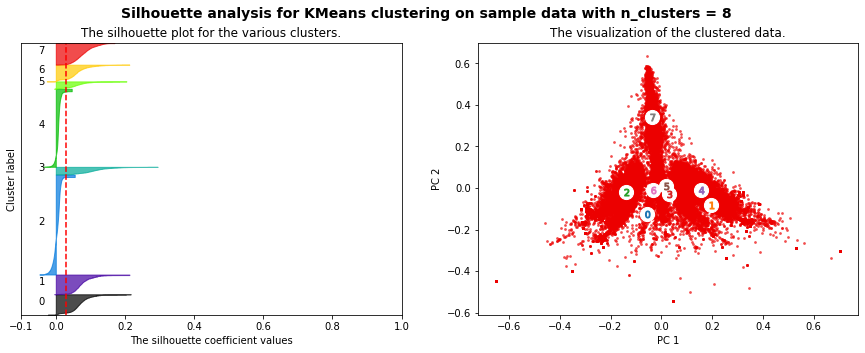

For n_clusters = 8, The average silhouette_score is : 0.029


In [8]:
plotSilhouette(num_cluster, X)

In [11]:
def plot_clusters(dataVects, km, num_cluster, terms=data_vectoriser.get_feature_names()):
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = 2).fit(dataVects.toarray())
    reduced_data = pca.transform(dataVects.toarray())
    # get distinguishing words to label
    components = pca.components_
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
    words = [terms[i] for i in keyword_ids]#Turn the ids into words.
    x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
    y = components[:,keyword_ids][1,:]
    
    cmap = matplotlib.cm.get_cmap("viridis")
    colors_p = [cmap(l/num_cluster) for l in km.labels_]
    
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))
    plt.xticks(())
    plt.yticks(())
    plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
    plt.show()

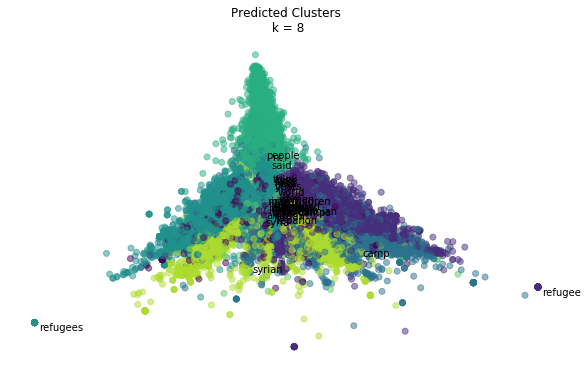

In [12]:
plot_clusters(dataVects, km, num_cluster)

## Topic Modelling

In [13]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [14]:
# creating dictionary
dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
# serialize
gensim.corpora.MmCorpus.serialize('data.mm', corpus)
data_mm = gensim.corpora.MmCorpus('data.mm')
# topic modelling
topics=10
data_lda = gensim.models.ldamodel.LdaModel(corpus=data_mm, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')

In [19]:
data_lda.save("data_lda")

In [23]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

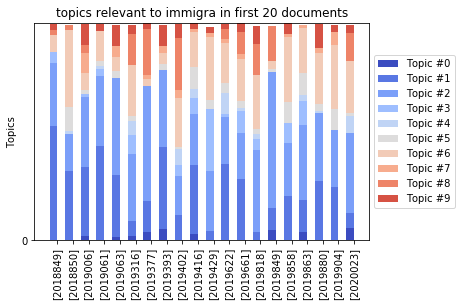

,text_id,title,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,2018849,This is the land of opportunity.,1990,"[(1, 0.5253326), (2, 0.29182473), (3, 0.049467...",0.000000,0.525333,0.291825,0.049467,0.000000,0.000000,0.077423,0.000000,0.021908,0.031148
1,2018850,Betting on regional booms.,1990,"[(1, 0.32013375), (2, 0.1705646), (4, 0.011127...",0.000000,0.320134,0.170565,0.000000,0.011128,0.112707,0.353165,0.000000,0.022035,0.000000
2,2019006,The evolution of jeans.,1990,"[(0, 0.020056149), (1, 0.31573403), (2, 0.3244...",0.020056,0.315734,0.324465,0.014248,0.000000,0.016050,0.079405,0.093236,0.034292,0.097715
3,2019061,Serve the people.,1990,"[(1, 0.433052), (2, 0.32190588), (3, 0.0335600...",0.000000,0.433052,0.321906,0.033560,0.012989,0.021633,0.138060,0.000000,0.000000,0.032976
4,2019063,No road to Tahuanti.,1990,"[(0, 0.013729661), (1, 0.28623122), (2, 0.4451...",0.013730,0.286231,0.445102,0.000000,0.000000,0.035097,0.065493,0.047809,0.000000,0.098859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48988,1211780587104751617,NaN,2019,"[(1, 0.21721244), (2, 0.4369094), (3, 0.073148...",0.000000,0.217212,0.436909,0.073149,0.000000,0.079044,0.000000,0.000000,0.169668,0.000000
48989,1211776688796946433,NaN,2019,"[(1, 0.06812125), (2, 0.8774235)]",0.000000,0.068121,0.877424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48990,1211766973111123968,NaN,2019,"[(1, 0.23640421), (2, 0.6924678)]",0.000000,0.236404,0.692468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48991,1211758501384671232,NaN,2019,"[(1, 0.058954235), (2, 0.78261083), (9, 0.1063...",0.000000,0.058954,0.782611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106398


In [25]:
n=20
title = "topics relevant to immigra in first {} documents".format(n)
plot_topics(data_lda, dictionary, data, title, n=n)

In [32]:
for i in range(data_lda.num_topics):
    print(i)
    print(data_lda.show_topic(i, topn=10))

0
[('germany', 0.22856016), ('rt', 0.11632945), ('afghan', 0.08557863), ('pakistan', 0.0304707), ('car', 0.024698313), ('road', 0.023409158), ('necessary', 0.017915605), ('park', 0.015567685), ('say', 0.014850633), ('second', 0.011937427)]
1
[('child', 0.07768689), ('refugee', 0.042045552), ('year', 0.039433867), ('family', 0.038635504), ('woman', 0.025444224), ('amp', 0.019832328), ('care', 0.017876063), ('school', 0.016327385), ('immigration', 0.01614182), ('community', 0.014536445)]
2
[('refugee', 0.21005954), ('amp', 0.022319108), ('syrian', 0.020367691), ('camp', 0.017445033), ('people', 0.016648902), ('country', 0.014674869), ('help', 0.011321003), ('right', 0.010514403), ('world', 0.0097528035), ('syria', 0.009571345)]
3
[('trump', 0.21694729), ('vote', 0.06052036), ('administration', 0.046995383), ('president', 0.042855576), ('obama', 0.041589543), ('white', 0.029156314), ('america', 0.023967758), ('muslim', 0.023902135), ('state', 0.015444435), ('say', 0.015199301)]
4
[('asylu

In [ ]:
#dynamic topic modelling - long run time (overnight)
#docs_per_year = list(data.groupby('year').size())
#num_topics = 4
#data_ldaseq = ldaseqmodel.LdaSeqModel(corpus=data_mm, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)

In [ ]:
#data_ldaseq.save("data_ldaseq")

In [ ]:
#data_ldaseq.print_topics(time=0)

In [38]:
#topic distribution divergence
from gensim.matutils import kullback_leibler

def plot_topic_divergence(data, years, num_topics=5):
    topic_prob, lda = get_topic_prob(data, years, num_topics)
    L = []
    for year_1 in topic_prob.keys():
        p = topic_prob[year_1]
        l = []
        for year_2 in topic_prob.keys():
            q = topic_prob[year_2]
            l.append(kullback_leibler(p, q))
        L.append(l)
    M = np.array(L)

    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(topic_prob.keys()), index = list(topic_prob.keys()))
    ax = sns.heatmap(div)
    plt.show()
    return lda
    
def get_topic_prob(data, years, num_topics=5):
    topic_prob = {}
    
    byyear, lda = get_topic_distribution(data, years, num_topics)
    # Convert to probability
    for yr in years:
        j=0
        for i in range(10):
            try:
                index, prob = byyear[yr][j]
            except IndexError:
                index = False

            if index == i:
                j+=1
                if yr in topic_prob:  
                    topic_prob[yr].append(prob)
                else:
                    topic_prob[yr] = [prob]
            else:
                if yr in topic_prob:  
                    topic_prob[yr].append(float(0))
                else:
                    topic_prob[yr] = [float(0)]
    return topic_prob, lda


def get_topic_distribution(data, years, num_topics=5):
    byyear = {}
    lda = {}
    # Get topic distribution for each year
    for yr in years:
        # get all text for each year
        text_df = data[data['year']==yr][['text']]
        text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
        text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
        # create dictionary
        data_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
        data_corpus_byyear = [data_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
        #lda
        lda_byyear = gensim.models.ldamodel.LdaModel(corpus=data_corpus_byyear, id2word=data_dictionary_byyear, num_topics=num_topics, alpha='auto', eta='auto')

        # place topic distribution in dictionary
        all_text = []
        for text in text_df['normalized_tokens']:
            all_text.extend(text)
        byyear[yr] = lda_byyear[data_dictionary_byyear.doc2bow(all_text)]
        lda[yr] = lda_byyear

        print('{} done'.format(yr))
    return byyear, lda

1990 done
1991 done
1992 done
1993 done
1994 done
1995 done
1996 done
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done


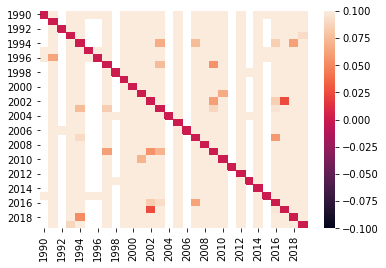

In [39]:
years = sorted(data['year'].unique())
lda_by_year = plot_topic_divergence(data, years, num_topics=5)

In [48]:
for yr in years:
    for i in range(5):
        print("Year: {}, Topic: {}".format(yr, i))
        print(lda_by_year[yr].show_topic(i, topn=10))

Year: 1990, Topic: 0
[('s', 0.017840486), ('not', 0.006985973), ('say', 0.006908972), ('think', 0.0066081136), ('people', 0.0062118117), ('go', 0.0049267206), ('year', 0.003969802), ('come', 0.0036370745), ('new', 0.0036005825), ('state', 0.0035364018)]
Year: 1990, Topic: 1
[('s', 0.021407982), ('not', 0.007896205), ('think', 0.0076712044), ('people', 0.005791726), ('mr', 0.0054905703), ('say', 0.0051753568), ('time', 0.0046452773), ('come', 0.0045770695), ('state', 0.004548571), ('year', 0.004498599)]
Year: 1990, Topic: 2
[('s', 0.019967554), ('say', 0.008148643), ('not', 0.0069843787), ('think', 0.006402402), ('people', 0.005672543), ('state', 0.004949473), ('year', 0.0044712457), ('country', 0.004032277), ('go', 0.0040151463), ('mr', 0.003925208)]
Year: 1990, Topic: 3
[('s', 0.01438683), ('say', 0.0075283726), ('think', 0.006533732), ('people', 0.0058847726), ('go', 0.005792419), ('not', 0.00568574), ('kuwait', 0.0039714817), ('country', 0.0039019762), ('world', 0.003696194), ('stat

## Word Embeddings

### word2vec

In [49]:
data_w2v = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

In [50]:
data_w2v.save('data_w2v')

In [28]:
data_w2v = gensim.models.word2vec.Word2Vec.load('data_w2v')

In [14]:
data_w2v.most_similar(positive=['refugee'])
#&amp

[('migrant', 0.6012977957725525),
 ('amp', 0.5887587070465088),
 ('haitians', 0.5604172348976135),
 ('somalis', 0.5538501739501953),
 ('rt', 0.5495731830596924),
 ('ppl', 0.5322973728179932),
 ('syrians', 0.5321687459945679),
 ('asylumseekers', 0.5292373895645142),
 ('bangladesh', 0.5288541316986084),
 ('returnee', 0.5232784152030945)]

In [11]:
data_w2v.most_similar(positive=['asylumseekers'])

[('migrant', 0.7603486776351929),
 ('deportation', 0.7543079853057861),
 ('repatriate', 0.7517817616462708),
 ('malaysia', 0.7434117794036865),
 ('sweden', 0.7328014373779297),
 ('detention', 0.7102818489074707),
 ('deport', 0.7089986801147461),
 ('visa', 0.7036485075950623),
 ('cubans', 0.7000539302825928),
 ('deportee', 0.6948468685150146)]

In [12]:
data_w2v.similarity('refugee','asylumseekers')

0.5292374

In [4]:
data_w2v.most_similar(positive=['refugee', 'illegal'], negative=['legal'])

[('somalis', 0.5950162410736084),
 ('migrant', 0.5657041072845459),
 ('illegally', 0.538986325263977),
 ('thousand', 0.5281550288200378),
 ('foreigner', 0.5270982980728149),
 ('ppl', 0.5215610265731812),
 ('syrians', 0.5181779861450195),
 ('mexicans', 0.5131580829620361),
 ('albanians', 0.5106081962585449),
 ('ten', 0.5056760311126709)]

In [ ]:
data_w2v.most_similar(positive=['refugee', 'independent'], negative=['dependent'])

In [7]:
data_w2v.similarity('refugee','help')

0.29370317

In [9]:
data_w2v.similarity('refugee','crisis')

0.20419632

In [29]:
def plot_embeddings(data_w2v, numWords, save=False, title=''):
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        plt.savefig("embeddingplot/{}".format(title))

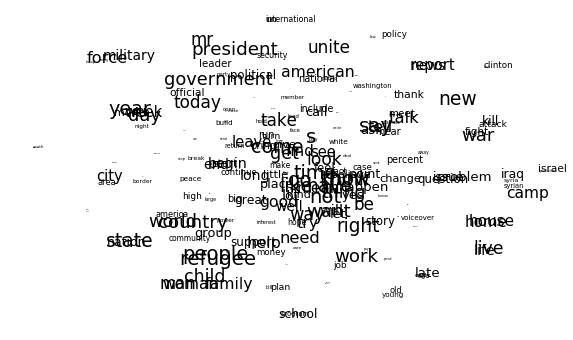

In [30]:
plot_embeddings(data_w2v, 200)

In [31]:
years=sorted(data['year'].unique())

1990
[('arm', 0.9825519323348999), ('include', 0.9801971912384033), ('camp', 0.9712827205657959), ('area', 0.9708086252212524), ('air', 0.9701187610626221), ('oman', 0.96980881690979), ('operation', 0.9695244431495667), ('german', 0.9695159196853638), ('frontier', 0.9688007831573486), ('trickle', 0.9681941270828247)]


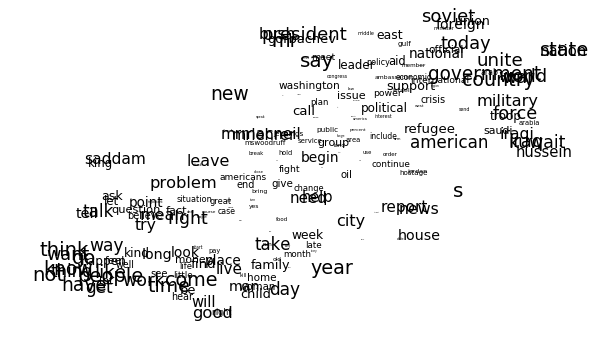

1991
[('border', 0.9422265291213989), ('area', 0.9305127263069153), ('camp', 0.925696849822998), ('kurdish', 0.9099204540252686), ('northern', 0.8899737596511841), ('flee', 0.8840764760971069), ('soldier', 0.8818421959877014), ('control', 0.8724536895751953), ('fight', 0.8722982406616211), ('troop', 0.8703101277351379)]


<Figure size 432x288 with 0 Axes>

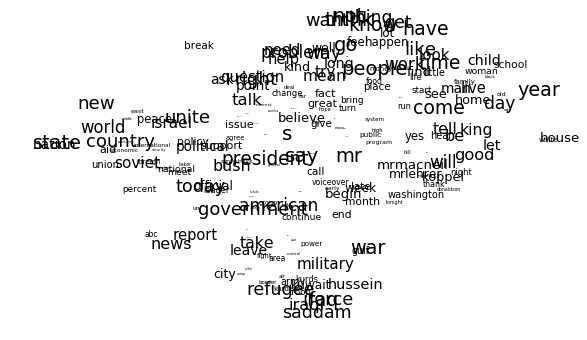

1992
[('force', 0.9958199262619019), ('un', 0.9932215213775635), ('european', 0.9853345155715942), ('government', 0.9850270748138428), ('war', 0.9850050210952759), ('military', 0.9836698770523071), ('country', 0.983270525932312), ('security', 0.9821006059646606), ('somalia', 0.9801747798919678), ('international', 0.9795713424682617)]


<Figure size 432x288 with 0 Axes>

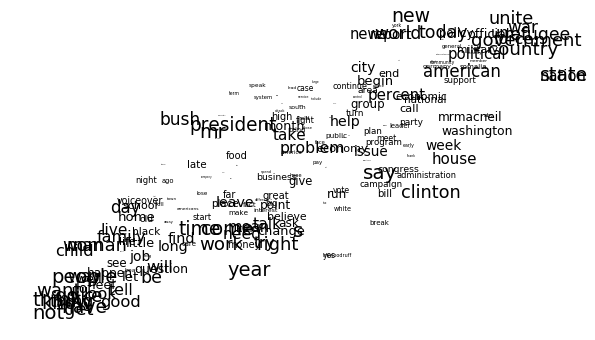

1993
[('un', 0.9919005632400513), ('force', 0.9900201559066772), ('bosnia', 0.9869915843009949), ('government', 0.9857748746871948), ('serbian', 0.983230710029602), ('international', 0.9829885959625244), ('bosnian', 0.9818511605262756), ('security', 0.9789678454399109), ('council', 0.9758855700492859), ('commissioner', 0.9751818776130676)]


<Figure size 432x288 with 0 Axes>

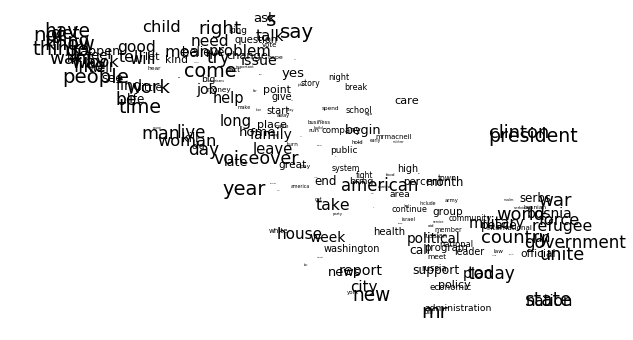

1994
[('war', 0.9476346969604492), ('troop', 0.9303616881370544), ('power', 0.9256570339202881), ('country', 0.9250197410583496), ('north', 0.9195793867111206), ('end', 0.9171408414840698), ('force', 0.9136254787445068), ('rwanda', 0.9133862257003784), ('cuban', 0.908642590045929), ('air', 0.9026957750320435)]


<Figure size 432x288 with 0 Axes>

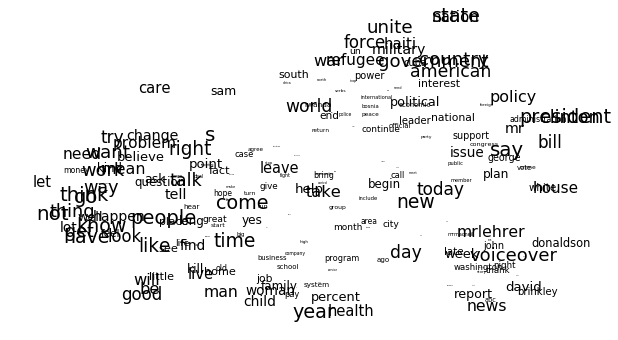

1995
[('srebrenica', 0.9995371103286743), ('commander', 0.9993927478790283), ('europe', 0.999323844909668), ('area', 0.9992658495903015), ('arm', 0.9992227554321289), ('resolution', 0.9992163181304932), ('participate', 0.9991892576217651), ('withdrawal', 0.9991728067398071), ('agency', 0.9991587400436401), ('relief', 0.999147891998291)]


<Figure size 432x288 with 0 Axes>

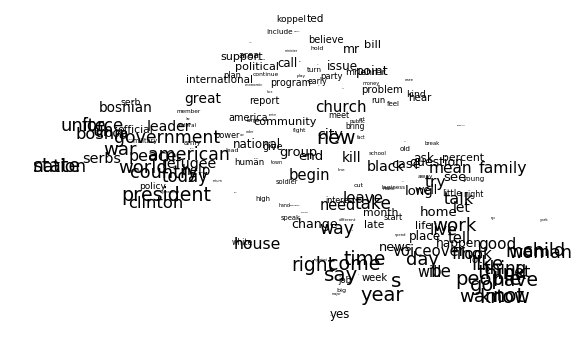

1996
[('force', 0.9919800758361816), ('camp', 0.9916692972183228), ('zaire', 0.9911525249481201), ('military', 0.9905664324760437), ('hutu', 0.9889692068099976), ('war', 0.9881272315979004), ('rwanda', 0.9879527688026428), ('troop', 0.9856542348861694), ('bosnia', 0.9851881265640259), ('border', 0.9844717383384705)]


<Figure size 432x288 with 0 Axes>

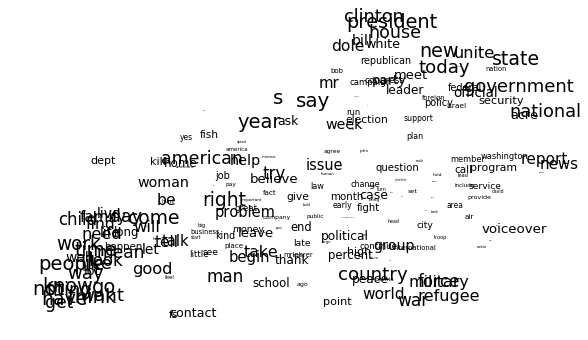

1997
[('camp', 0.9998468160629272), ('leave', 0.9998461604118347), ('thousand', 0.9998430013656616), ('border', 0.9998408555984497), ('hutu', 0.999840497970581), ('2', 0.9998394250869751), ('learn', 0.9998347759246826), ('kill', 0.9998342990875244), ('area', 0.999832272529602), ('battle', 0.9998315572738647)]


<Figure size 432x288 with 0 Axes>

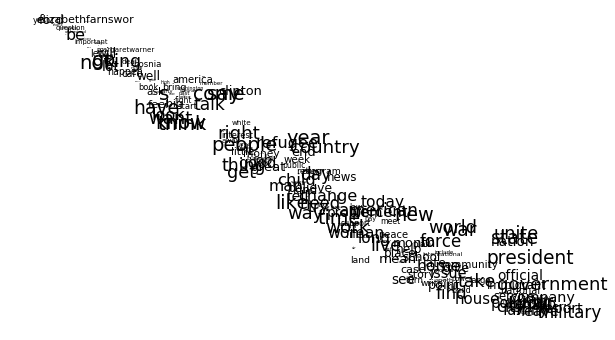

1998
[('grow', 0.999882698059082), ('raise', 0.9998744130134583), ('cause', 0.9998706579208374), ('leave', 0.9998664855957031), ('fight', 0.9998643398284912), ('kill', 0.9998641610145569), ('kosovo', 0.9998631477355957), ('soldier', 0.999861478805542), ('place', 0.9998606443405151), ('arrive', 0.9998598098754883)]


<Figure size 432x288 with 0 Axes>

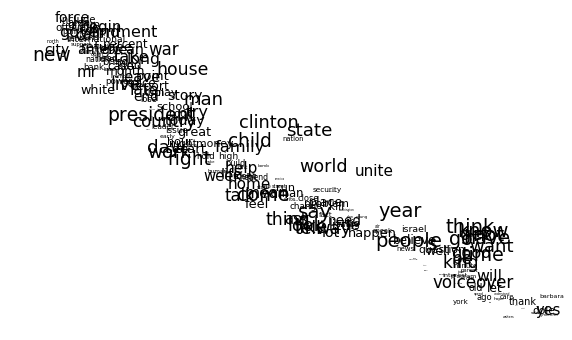

1999
[('albanians', 0.99408358335495), ('ethnic', 0.9919427633285522), ('serbs', 0.9887994527816772), ('serb', 0.9884753227233887), ('cleanse', 0.9874958992004395), ('flee', 0.9872429370880127), ('albanian', 0.9867549538612366), ('army', 0.9851145148277283), ('kill', 0.9825496673583984), ('attack', 0.9817724227905273)]


<Figure size 432x288 with 0 Axes>

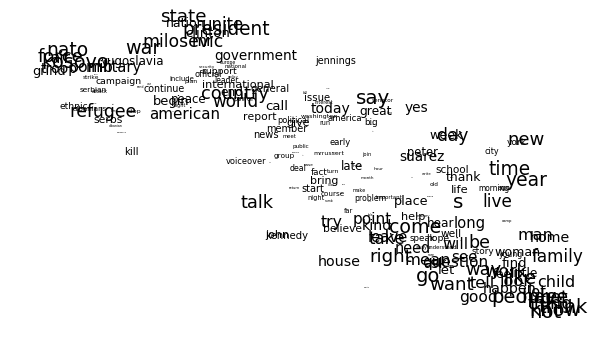

2000
[('camp', 0.9985600709915161), ('david', 0.9983068704605103), ('west', 0.9982329607009888), ('return', 0.9981412887573242), ('thousand', 0.998096227645874), ('bank', 0.9980142116546631), ('border', 0.9979629516601562), ('sovereignty', 0.9978333711624146), ('gaza', 0.9978263974189758), ('burundi', 0.9978218078613281)]


<Figure size 432x288 with 0 Axes>

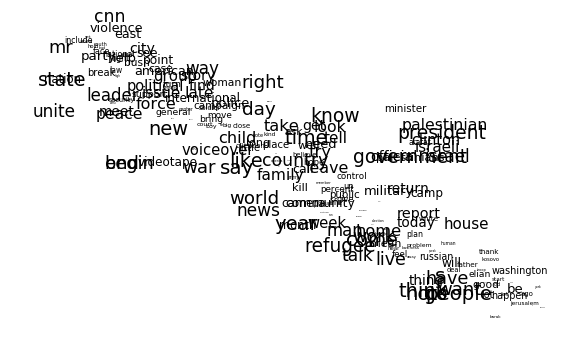

2001
[('kabul', 0.9977775812149048), ('flee', 0.9975963830947876), ('border', 0.9975849986076355), ('troop', 0.9972675442695618), ('civilian', 0.9972529411315918), ('near', 0.9972079396247864), ('afghan', 0.9971967339515686), ('control', 0.9971174001693726), ('soldier', 0.9970677495002747), ('army', 0.9970635771751404)]


<Figure size 432x288 with 0 Axes>

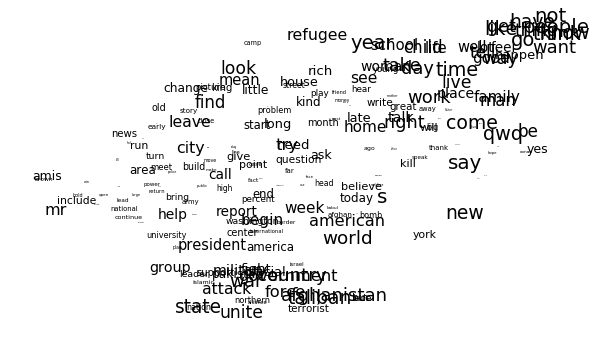

2002
[('camp', 0.9757407903671265), ('jenin', 0.9752457141876221), ('gaza', 0.9552286863327026), ('shamshatoo', 0.9548664093017578), ('strip', 0.9530376195907593), ('nablus', 0.9506851434707642), ('town', 0.9460797309875488), ('kill', 0.9440363645553589), ('force', 0.9427011013031006), ('balata', 0.9420186281204224)]


<Figure size 432x288 with 0 Axes>

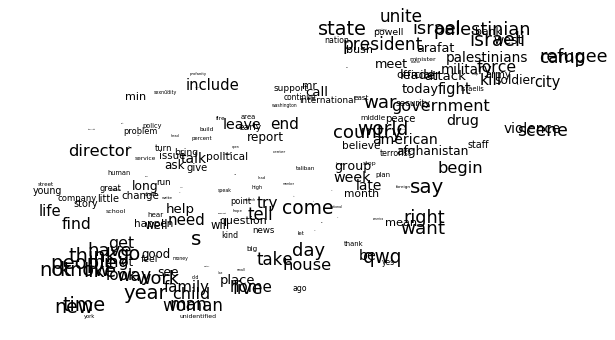

2003
[('organization', 0.9996283054351807), ('area', 0.9996280670166016), ('effort', 0.999620258808136), ('community', 0.9996116161346436), ('operation', 0.9996114373207092), ('education', 0.9996108412742615), ('recent', 0.9995979070663452), ('return', 0.9995930790901184), ('accord', 0.999592125415802), ('army', 0.999591588973999)]


<Figure size 432x288 with 0 Axes>

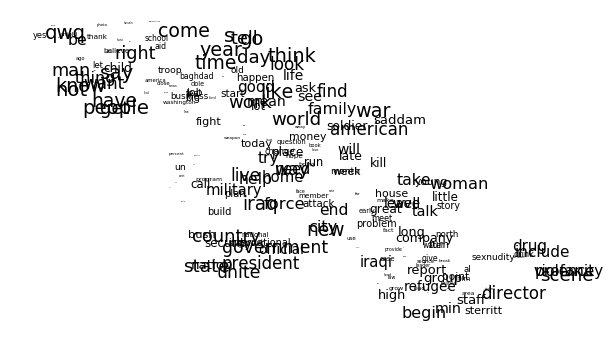

2004
[('sudanese', 0.9995408058166504), ('camp', 0.9995260238647461), ('force', 0.9995230436325073), ('palestinians', 0.9995146989822388), ('government', 0.9995090961456299), ('flee', 0.9994856119155884), ('leader', 0.9994828104972839), ('security', 0.9994796514511108), ('month', 0.999475359916687), ('peace', 0.999467670917511)]


<Figure size 432x288 with 0 Axes>

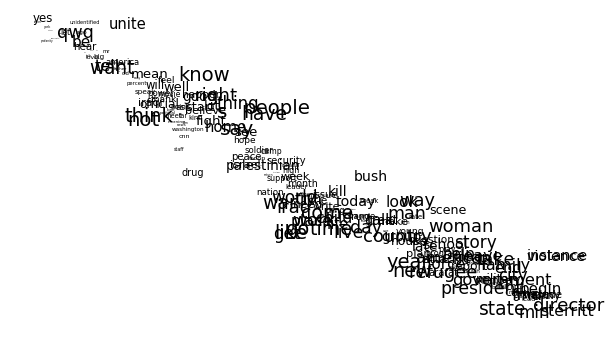

2005
[('atlanta', 0.9997150897979736), ('thousand', 0.9997140169143677), ('hundred', 0.9997009038925171), ('entire', 0.999691367149353), ('major', 0.9996829032897949), ('serve', 0.999677836894989), ('college', 0.9996774196624756), ('base', 0.9996770024299622), ('board', 0.9996717572212219), ('culture', 0.9996715188026428)]


<Figure size 432x288 with 0 Axes>

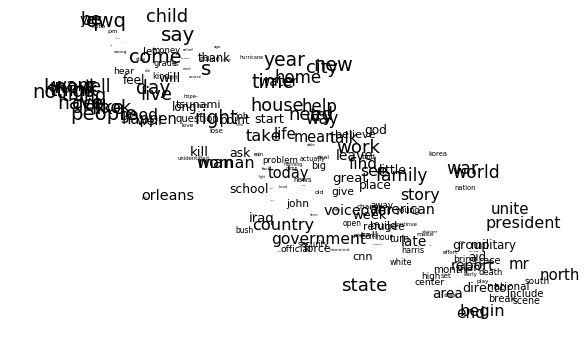

2006
[('threat', 0.999239444732666), ('weapon', 0.9991055130958557), ('visit', 0.999074399471283), ('flee', 0.9990569949150085), ('message', 0.9990465641021729), ('chinese', 0.9990452527999878), ('mexican', 0.9990183115005493), ('capability', 0.9990004301071167), ('likely', 0.9989969730377197), ('launch', 0.9989709854125977)]


<Figure size 432x288 with 0 Axes>

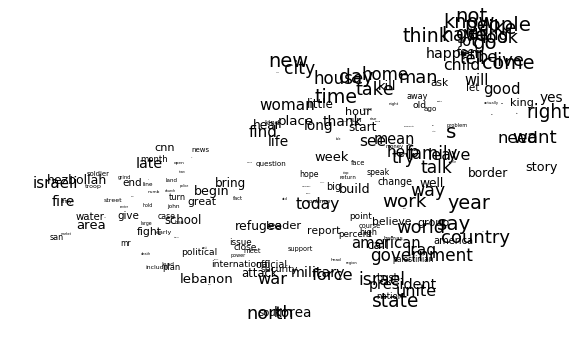

2007
[('lebanon', 0.9985109567642212), ('palestinian', 0.9979705810546875), ('government', 0.9976836442947388), ('iraqi', 0.9975912570953369), ('camp', 0.9973580837249756), ('iraq', 0.9972963333129883), ('force', 0.9972402453422546), ('iraqis', 0.9970780611038208), ('palestinians', 0.9970473051071167), ('arab', 0.9969131946563721)]


<Figure size 432x288 with 0 Axes>

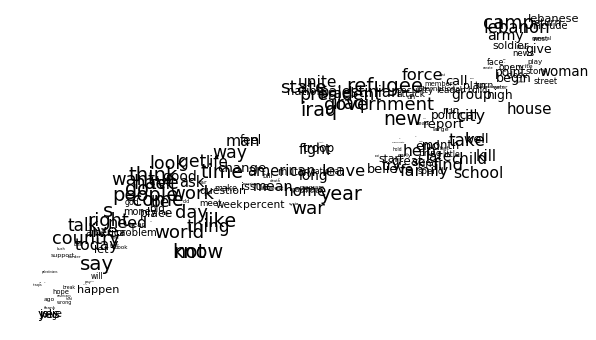

2008
[('troop', 0.9996925592422485), ('force', 0.9996825456619263), ('aid', 0.9996741414070129), ('bomb', 0.9996722340583801), ('humanitarian', 0.9996665716171265), ('train', 0.9996631145477295), ('medium', 0.9996598362922668), ('government', 0.9996592402458191), ('figure', 0.9996575117111206), ('flee', 0.9996558427810669)]


<Figure size 432x288 with 0 Axes>

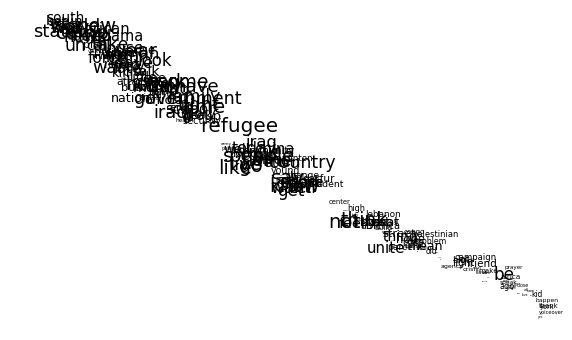

2009
[('place', 0.999363362789154), ('dry', 0.9993326663970947), ('sit', 0.999324381351471), ('kenya', 0.9993233680725098), ('parent', 0.9993219375610352), ('poverty', 0.9993194937705994), ('be', 0.9993194341659546), ('condition', 0.9993168115615845), ('raise', 0.9993117451667786), ('rt', 0.9993101358413696)]


<Figure size 432x288 with 0 Axes>

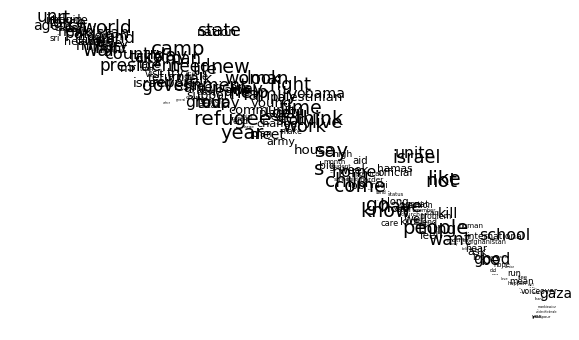

2010
[('visit', 0.9995980262756348), ('learn', 0.9995725750923157), ('happy', 0.999564528465271), ('rt', 0.9995642900466919), ('medium', 0.9995640516281128), ('bear', 0.9995639324188232), ('place', 0.9995586276054382), ('cause', 0.9995582103729248), ('woman', 0.9995537400245667), ('thousand', 0.9995496869087219)]


<Figure size 432x288 with 0 Axes>

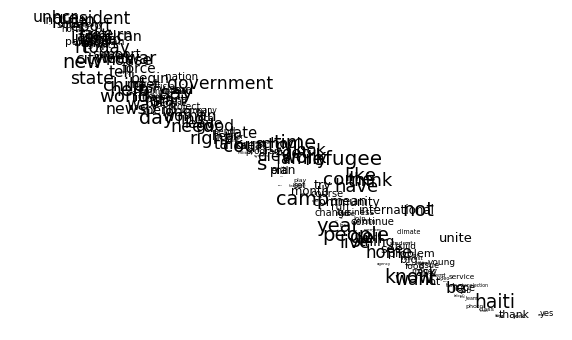

2011
[('dadaab', 0.9991428852081299), ('somalia', 0.9990794658660889), ('happy', 0.9990571737289429), ('photo', 0.999014675617218), ('amp', 0.9990139007568359), ('kenya', 0.99901282787323), ('dry', 0.9990126490592957), ('family', 0.9990068674087524), ('day', 0.9990066289901733), ('woman', 0.999000072479248)]


<Figure size 432x288 with 0 Axes>

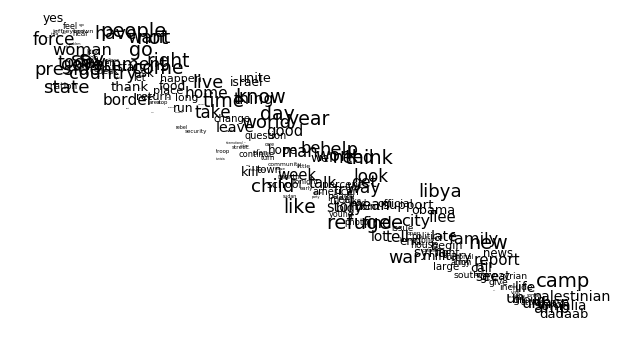

2012
[('turkey', 0.995083749294281), ('syria', 0.9950438141822815), ('border', 0.994732141494751), ('camp', 0.9940082430839539), ('flee', 0.9938212633132935), ('force', 0.9937492609024048), ('lebanon', 0.9933260679244995), ('jordan', 0.9931519031524658), ('child', 0.9928501844406128), ('turkish', 0.9927040338516235)]


<Figure size 432x288 with 0 Axes>

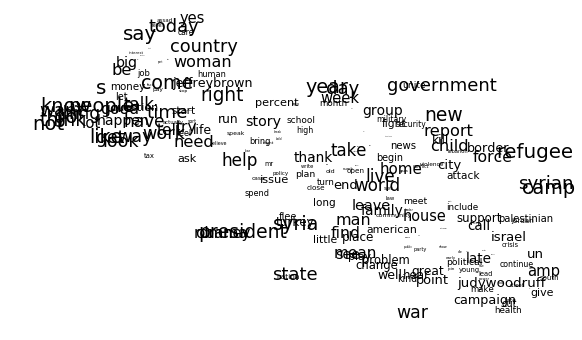

2013
[('jordan', 0.9893340468406677), ('child', 0.9873907566070557), ('lebanon', 0.9837696552276611), ('syria', 0.9830915927886963), ('camp', 0.9822268486022949), ('border', 0.9815849661827087), ('zaatari', 0.980853796005249), ('flee', 0.9804591536521912), ('syrian', 0.9801596999168396), ('live', 0.9780973196029663)]


<Figure size 432x288 with 0 Axes>

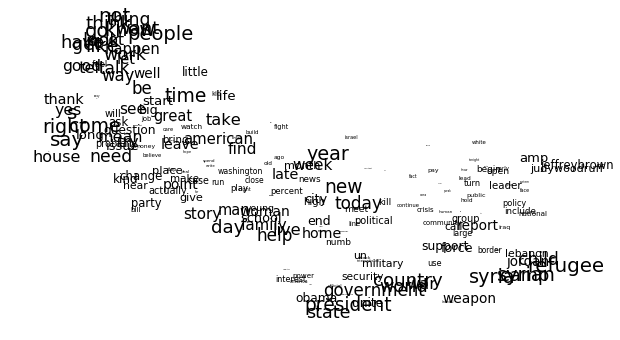

2014
[('camp', 0.9689072370529175), ('syrian', 0.968614935874939), ('jordan', 0.9550503492355347), ('force', 0.949212908744812), ('gaza', 0.9443520307540894), ('flee', 0.9442063570022583), ('border', 0.9440785050392151), ('alshati', 0.9404203295707703), ('iraqi', 0.9378629922866821), ('city', 0.9313669204711914)]


<Figure size 432x288 with 0 Axes>

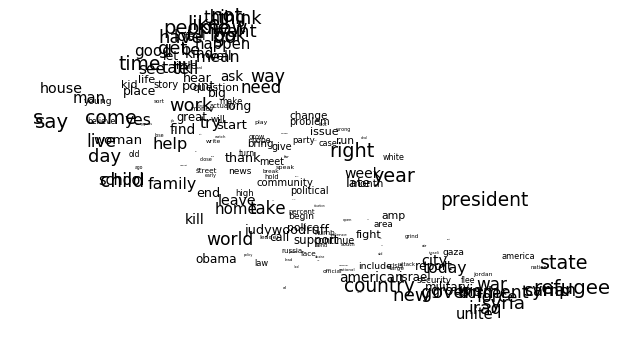

2015
[('camp', 0.9358006715774536), ('migrant', 0.9204598665237427), ('syria', 0.9127933979034424), ('border', 0.9118344187736511), ('war', 0.9109643697738647), ('europe', 0.9053744673728943), ('crisis', 0.9046981334686279), ('flee', 0.9029965400695801), ('force', 0.9021162986755371), ('syrian', 0.8993647694587708)]


<Figure size 432x288 with 0 Axes>

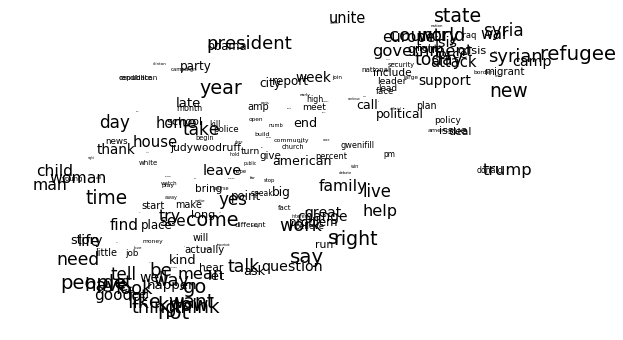

2016
[('camp', 0.9999422430992126), ('amp', 0.9999405741691589), ('need', 0.9999403953552246), ('woman', 0.9999402761459351), ('not', 0.9999393224716187), ('child', 0.9999384880065918), ('day', 0.9999368786811829), ('help', 0.9999340176582336), ('muslim', 0.9999340176582336), ('time', 0.9999322295188904)]


<Figure size 432x288 with 0 Axes>

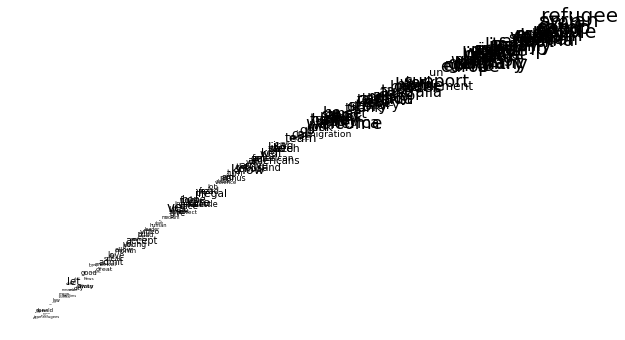

2017
[('amp', 0.9999464750289917), ('work', 0.9999439120292664), ('camp', 0.9999432563781738), ('force', 0.9999421834945679), ('s', 0.9999407529830933), ('not', 0.9999393224716187), ('face', 0.9999364614486694), ('child', 0.9999364614486694), ('help', 0.9999339580535889), ('migrant', 0.9999337792396545)]


<Figure size 432x288 with 0 Axes>

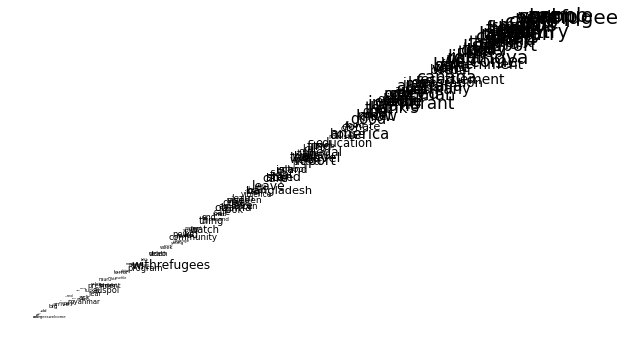

2018
[('woman', 0.9999265670776367), ('place', 0.999925434589386), ('need', 0.9999215602874756), ('child', 0.9999212622642517), ('be', 0.9999208450317383), ('migrant', 0.9999185800552368), ('face', 0.9999183416366577), ('work', 0.9999166131019592), ('s', 0.9999151825904846), ('border', 0.9999140501022339)]


<Figure size 432x288 with 0 Axes>

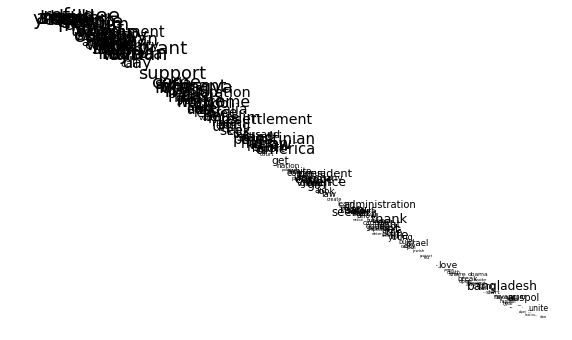

2019
[('woman', 0.9999284148216248), ('medium', 0.9999263882637024), ('child', 0.9999245405197144), ('help', 0.9999241828918457), ('place', 0.9999191761016846), ('work', 0.9999167919158936), ('camp', 0.9999167919158936), ('man', 0.9999155402183533), ('border', 0.9999147653579712), ('time', 0.9999141693115234)]


<Figure size 432x288 with 0 Axes>

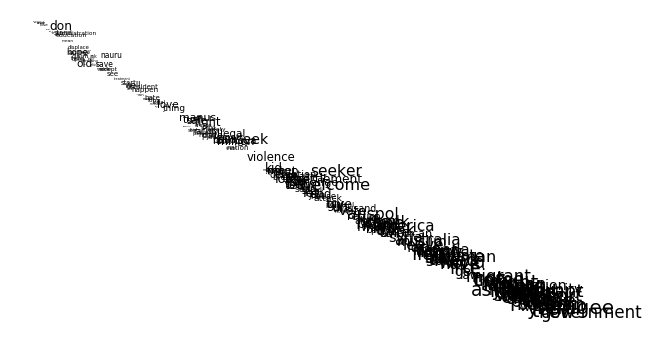

<Figure size 432x288 with 0 Axes>

In [32]:
# Year on year
yearly_w2v = {}
for yr in years:
    yearly = data[data['year']==yr]
    data_w2v = gensim.models.word2vec.Word2Vec(yearly['normalized_sents'].sum())
    yearly_w2v[yr] = data_w2v
    print(yr)
    print(data_w2v.most_similar(positive=['refugee']))
    plot_embeddings(data_w2v, 200, save=True, title='{}'.format(yr))

In [33]:
yearly_w2v

{1990: <gensim.models.word2vec.Word2Vec at 0x10b1a6c40>,
 1991: <gensim.models.word2vec.Word2Vec at 0x14ababeb0>,
 1992: <gensim.models.word2vec.Word2Vec at 0x14aa41400>,
 1993: <gensim.models.word2vec.Word2Vec at 0x149cfe3d0>,
 1994: <gensim.models.word2vec.Word2Vec at 0x149abddf0>,
 1995: <gensim.models.word2vec.Word2Vec at 0x1467be430>,
 1996: <gensim.models.word2vec.Word2Vec at 0x149cfe520>,
 1997: <gensim.models.word2vec.Word2Vec at 0x148917f40>,
 1998: <gensim.models.word2vec.Word2Vec at 0x151a0e5b0>,
 1999: <gensim.models.word2vec.Word2Vec at 0x1519fd370>,
 2000: <gensim.models.word2vec.Word2Vec at 0x18ae7d580>,
 2001: <gensim.models.word2vec.Word2Vec at 0x148917250>,
 2002: <gensim.models.word2vec.Word2Vec at 0x284a38a30>,
 2003: <gensim.models.word2vec.Word2Vec at 0x1484e3b20>,
 2004: <gensim.models.word2vec.Word2Vec at 0x28a89cbe0>,
 2005: <gensim.models.word2vec.Word2Vec at 0x28bc29400>,
 2006: <gensim.models.word2vec.Word2Vec at 0x28a89c8e0>,
 2007: <gensim.models.word2vec.

### doc2vec

In [11]:
def tag_docs(data):
    taggedDocs = []
    for index, row in data.iterrows():
        #Just doing a simple keyword assignment
        docKeywords = [row['year']]
        docKeywords.append(row['text_id'])
        docKeywords.append(row['genre'])
        docKeywords.append(row['word_count'])
        taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
    return taggedDocs

data['tagged_docs'] = tag_docs(data)

In [ ]:
# memory error
#data_d2v = gensim.models.doc2vec.Doc2Vec(data['tagged_docs'],vector_size=100)

In [ ]:
data_d2v.save("data_d2v")

In [ ]:
data_d2v.most_similar(positive = ['immigrants','illegal'], negative = ['legal'], topn = 10)

In [ ]:
def most_similar_by_year(data_d2v,years):
    for yr in years:
        print(yr)
        print(data_d2v.most_similar( [ data_d2v.docvecs[yr] ], topn=5))
        print()

years = range(1990,2016)        
most_similar_by_year(data_d2v, years)

In [ ]:
genre = list(data['genre'].unique())       
most_similar_by_year(data_d2v, genre)

In [ ]:
def plot_similarity(data_d2v, targetDocs):
    heatmapMatrixD = []
    for tagOuter in targetDocs:
        column = []
        tagVec = data_d2v.docvecs[tagOuter].reshape(1, -1)
        for tagInner in targetDocs:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, data_d2v.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrixD.append(column)
    heatmapMatrixD = np.array(heatmapMatrixD)
    fig, ax = plt.subplots()
    hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
    cbar = plt.colorbar(hmap)

    cbar.set_label('cosine similarity', rotation=270)
    a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
    a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

    a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
    a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
plot_similarity(data_d2v, list(data['year'].unique()))

In [ ]:
plot_similarity(data_d2v, list(data['genre'].unique()))

### change over time

In [15]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [16]:
data_rawEmbeddings, data_comparedEmbeddings = compareModels(data, 'year')

In [19]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

def plot_divergence(targetWord, comparedEmbeddings):
    pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
    fig, ax = plt.subplots(figsize = (10, 7))
    sns.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
    ax.set_xlabel("Starting year")
    ax.set_ylabel("Final year")
    ax.set_ylabel("Final year")
    ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
    plt.show()

refugee


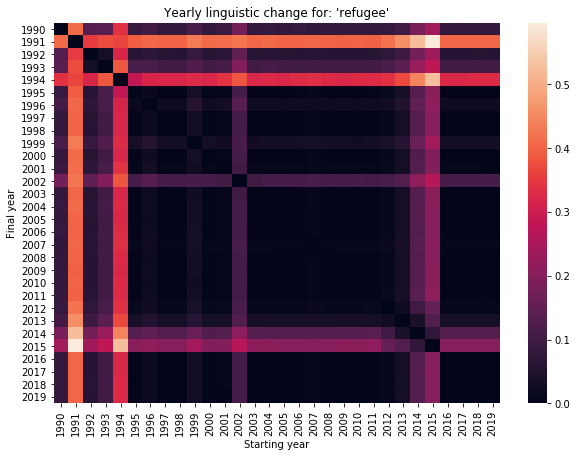

In [20]:
plot_divergence('refugee', data_comparedEmbeddings)

border


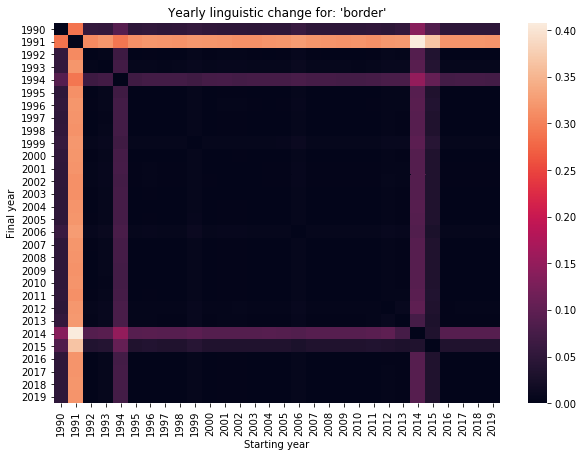

In [26]:
plot_divergence('border', data_comparedEmbeddings)

crisis


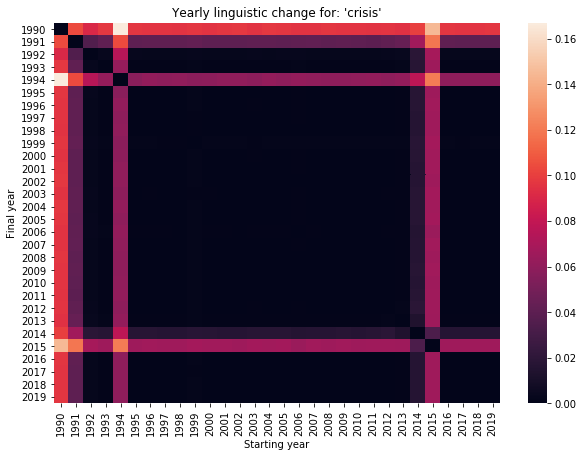

In [27]:
plot_divergence('crisis', data_comparedEmbeddings)

In [28]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

data_wordDivergences = findMostDivergent(data_comparedEmbeddings)

Found 729 words to compare


In [29]:
# most divergence
data_wordDivergences[:20]

[('state', 18.300449281930923),
 ('unite', 17.992438949644566),
 ('nation', 14.835680544376373),
 ('president', 13.80653902888298),
 ('union', 12.515876442193985),
 ('news', 12.175233036279678),
 ('new', 11.469517663121223),
 ('iraq', 10.214055359363556),
 ('middle', 9.922540128231049),
 ('east', 9.310654044151306),
 ('force', 9.035454213619232),
 ('house', 8.815692812204361),
 ('department', 8.794910550117493),
 ('minister', 8.19817104935646),
 ('not', 8.074066758155823),
 ('have', 7.182254672050476),
 ('military', 7.107830822467804),
 ('world', 6.83979469537735),
 ('know', 6.689740359783173),
 ('today', 6.610923707485199)]

In [30]:
# least divergence
data_wordDivergences[-20:]

[('culture', 0.05394464731216431),
 ('christians', 0.05386543273925781),
 ('card', 0.053667545318603516),
 ('voice', 0.05357581377029419),
 ('huge', 0.05342775583267212),
 ('especially', 0.05321460962295532),
 ('host', 0.05266225337982178),
 ('deliver', 0.05212980508804321),
 ('keep', 0.05212146043777466),
 ('advocate', 0.051025390625),
 ('list', 0.05064654350280762),
 ('lock', 0.050411105155944824),
 ('document', 0.048519134521484375),
 ('safety', 0.04770559072494507),
 ('victim', 0.046665728092193604),
 ('criminal', 0.04655766487121582),
 ('freedom', 0.04589110612869263),
 ('expose', 0.044013381004333496),
 ('reality', 0.033497750759124756),
 ('lack', 0.03167712688446045)]